# Altair: final test
In this notebook, we try to create interdependent graphs using Altair and produce HTML and pdf files using these graphs.

In [1]:
import sys

sys.path.insert(0, '..')

import altair as alt
import pandas as pd

from datetime import datetime
from dateutil import parser

from manuscripts.manuscripts2.new_functions import Index, Query, get_timeseries, buckets_to_df

git_index_name1 = "perceval_git"
git_index_name2 = "grimoire_elk_git"
git_index_name3 = "manuscripts_git"
git_index1 = Index(index_name=git_index_name1)
git_index2 = Index(index_name=git_index_name2)
git_index3 = Index(index_name=git_index_name3)

Here, we will be looking at 3 repositories which come under one project 'grimoirelab'.
Using Altair, we have created two bar plots, both of them interact with each other.

Here, we are querying elasticsearch to get the `hash`, `commit_date` and `author_name` from these repos which are the main fields that we will be analysing

In [2]:
commits1 = Query(git_index1)
all_commits1 = commits1.fetch_results_from_source("hash", "commit_date", "author_name", dataframe=True)
all_commits1["commit_date"] = all_commits1["commit_date"].apply(parser.parse)

commits2 = Query(git_index2)
all_commits2 = commits2.fetch_results_from_source("hash", "commit_date", "author_name", dataframe=True)
all_commits2["commit_date"] = all_commits2["commit_date"].apply(parser.parse)

commits3 = Query(git_index3)
all_commits3 = commits3.fetch_results_from_source("hash", "commit_date", "author_name", dataframe=True)
all_commits3["commit_date"] = all_commits3["commit_date"].apply(parser.parse)

### Commits by authors, distributed over time.

In the first diagram, we will look at only `perceval_github` repo. The first graph contains the number of commits distributed overtime, per month.

The second graph contains the number of commits per user. When we select a time period in the first graph the distribution of the corresponding number of commits, per author, that were made in that time period are shown.

When we select a user from the second graph, then the distribution of all the commits made by that user over time is shown.

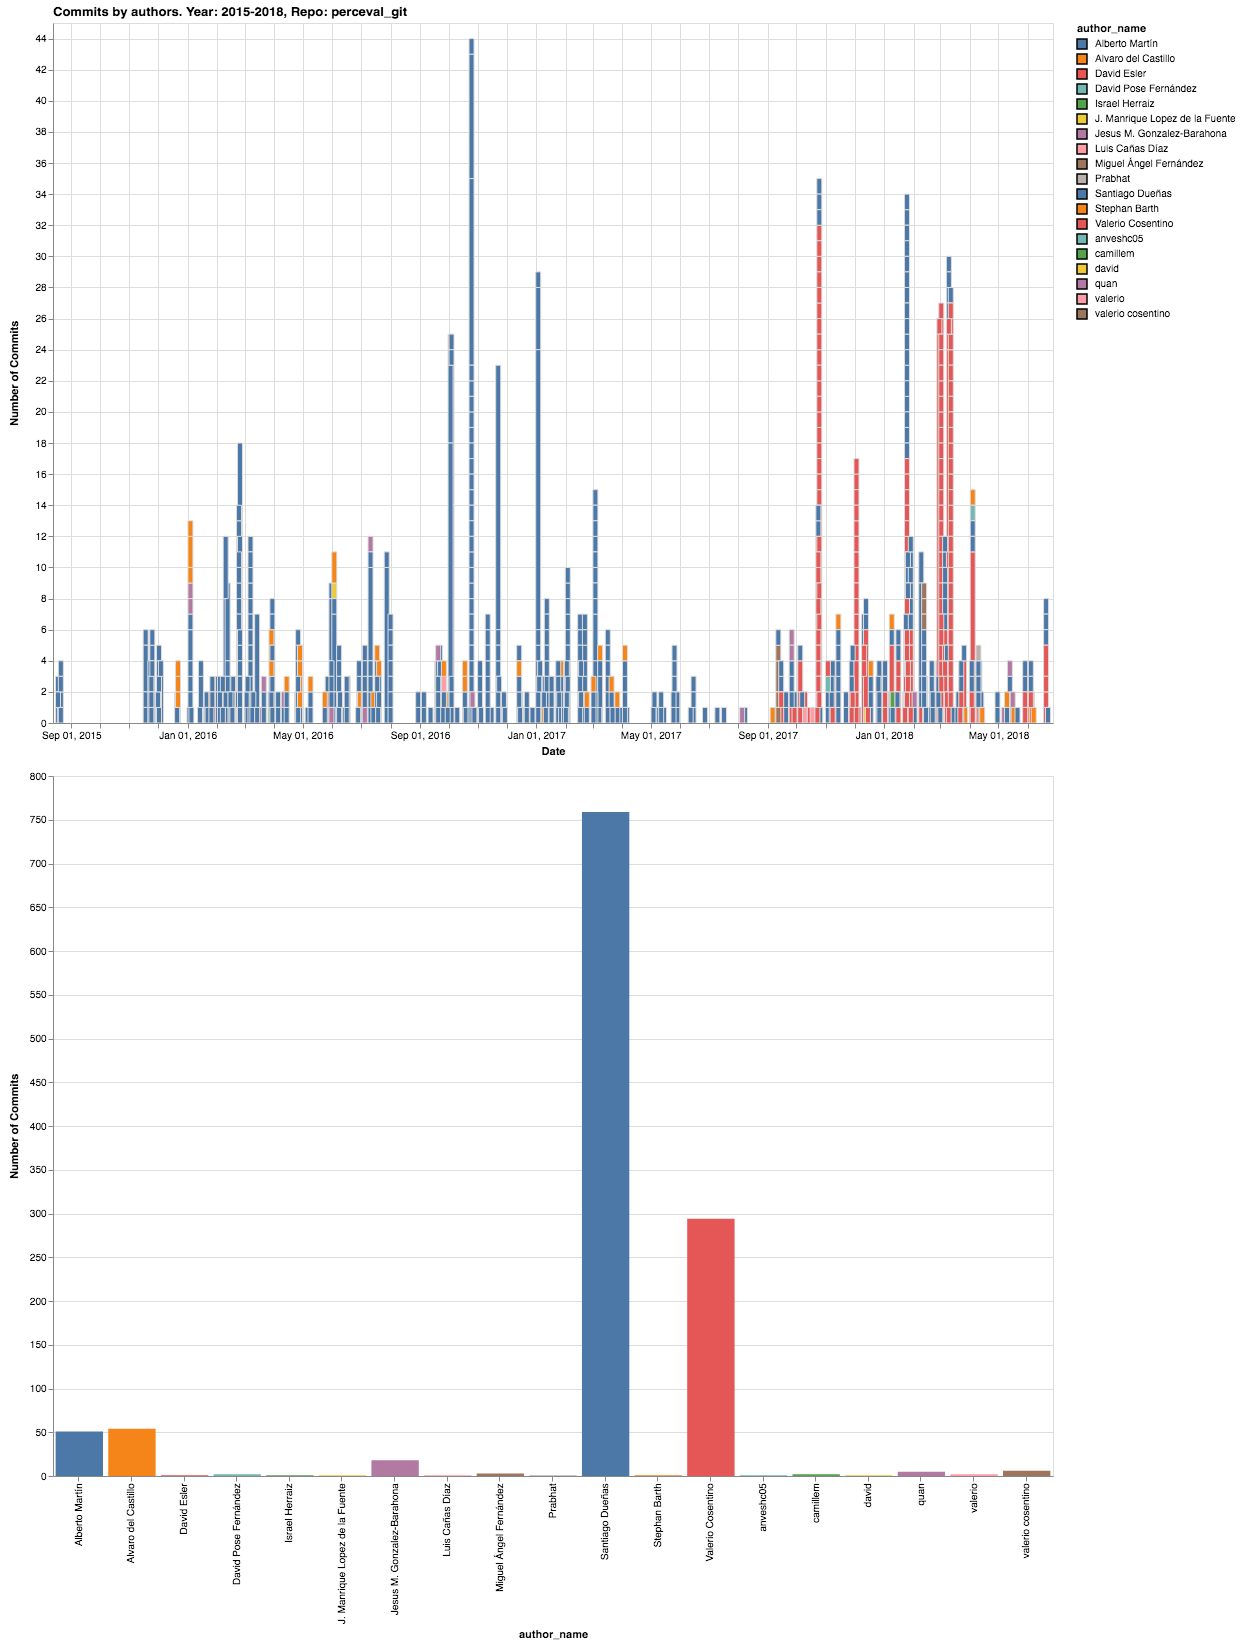

In [3]:
color = alt.Color('author_name', type='nominal')

brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

width = len(all_commits1['author_name'].unique())*20
max_date = all_commits1["commit_date"].max()
min_date = all_commits1["commit_date"].min()

points = alt.Chart().mark_bar(stroke="2").encode(
    alt.X('yearmonthdate(commit_date):T',
          axis=alt.Axis(title='Date')
         ),
    alt.Y('count(hash):Q',
        axis=alt.Axis(title='Number of Commits'),
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    tooltip=['author_name:N', "commit_date:N"]
).properties(
    width=1000,
    height=700,
).add_selection(
    brush
).transform_filter(
    click
)

bars = alt.Chart().mark_bar().encode(
    alt.Y('count()',
          axis=alt.Axis(title='Number of Commits')
         ),
    alt.X('author_name:N'),
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=1000,
    height=700
).add_selection(
    click
)

chart1 = alt.vconcat(points, bars,
    data=all_commits1,
    title="Commits by authors. Year: {}-{}, Repo: {}".format(min_date.year, max_date.year, git_index_name1)
)
chart1

We will save the above graphs a HTML file in the `html` sub folder.

In [4]:
# produce an html file containing the above plots
chart1.save("html/commits_by_authors_perceval.html")

We can also save the above graphs as images in `png` format.

In [5]:
chart1.save("images/commits_by_authors_perceval.png")

We can then save this png file as a PDF.

In [6]:
from fpdf import FPDF
pdf = FPDF()

pdf.add_page()
pdf.image("images/commits_by_authors_perceval.png", x=5, y=5, w=200, h=280)

### Commits in the whole project, distributed over time and differentiated by authors

This is much more interesting than the above graphs.

In this, we are looking at all the git data sources for the repos under a project. As shown above, we are looking at:
- perceval
- manuscripts &
- grimoire-elk

repos.

In the first graph, we will have the total commits in all the repos distributed over time.

In the second graph, we will have the commits made by each author in these projects differentiated(distributed).

In the second graph, when you select the repo you can see the distribution of the commits made under that repo over time in the first graph.

In [7]:
all_commits1['repo_name'] = git_index_name1
all_commits2['repo_name'] = git_index_name2
all_commits3['repo_name'] = git_index_name3
all_commits = pd.concat([all_commits1, all_commits2, all_commits3])

In [8]:
all_commits.groupby('repo_name').count()

,author_name,commit_date,hash
repo_name,,,
grimoire_elk_git,2040,2040,2040
manuscripts_git,206,206,206
perceval_git,1204,1204,1204


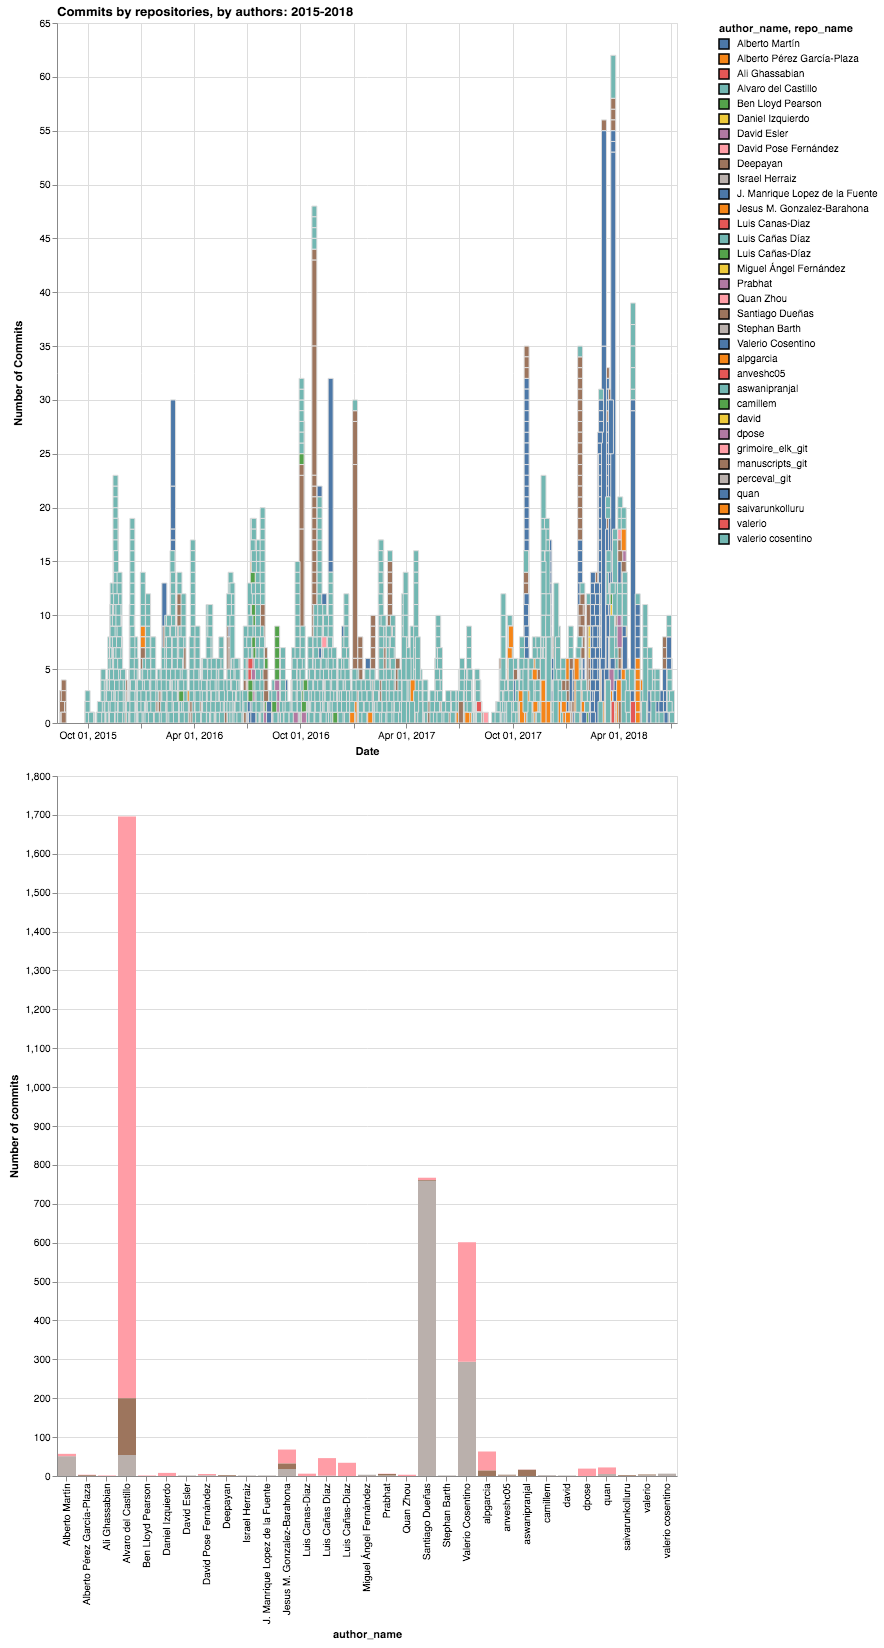

In [9]:
color_by_author = alt.Color('author_name:N')
color_by_repo = alt.Color('repo_name:N')

brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

width = len(all_commits['author_name'].unique())*20
max_date = all_commits["commit_date"].max()
min_date = all_commits["commit_date"].min()

points = alt.Chart().mark_bar(stroke="2").encode(
    alt.X('yearmonthdate(commit_date):T',
          axis=alt.Axis(title='Date')
         ),
    alt.Y('count(hash):Q',
        axis=alt.Axis(title='Number of Commits'),
    ),
    color=alt.condition(brush, color_by_author, alt.value('lightgray')),
    tooltip=["author_name", "commit_date", "repo_name"]
).properties(
    width=width,
    height=700,
).add_selection(
    brush
).transform_filter(
    click
)

bars = alt.Chart().mark_bar().encode(
    alt.Y('count(hash)',
          axis=alt.Axis(title="Number of commits")
         ),
    x='author_name:N',
    color=alt.condition(click, color_by_repo, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=width,
    height=700
).add_selection(
    click
)

chart2 = alt.vconcat(points, bars,
    data=all_commits,
    title="Commits by repositories, by authors: {}-{}".format(min_date.year, max_date.year)
)
chart2

We can save the above graph as an HTML too, same as above.

In [10]:
chart2.savechart("html/commits_by_orgs.html")

We can also save the above graphs as images in `png` format.

In [11]:
chart2.save("images/commits_by_orgs.png")

We added a page to our pdf named `altair_test.pdf`, in the pdfs folder. We will add another page to it containing the above graph and actually create the pdf. 

In [12]:
pdf.add_page()
pdf.image("images/commits_by_orgs.png", x=5, y=5, w=200, h=280)
pdf.output('pdfs/altair_test.pdf', "F")

''

Now, after all this, we want to have all these graphs in a single HTML page so that the user can freely interact with these graphs and don't have to open different HTML files for each of the graphs. We will concatinate the above four graphs and output them in an HTML file.

In [13]:
all_charts = alt.vconcat(chart1, chart2)

In [14]:
all_charts.savechart("html/final_charts.html")

And that concludes this notebook. 

I was unaware of how cool this library is but now I am aware of it's power. It will be a great addition to the manuscripts reporting tool kit.